The Augmented Lagrangian
$$
L_{\sigma}(c,b,u;\lambda)=\frac{1}{2}c^{\top}Kc+C\|u_+\|_0+\frac{\sigma}{2}\|u-\big({\mathbf 1}-{\rm diag}(y)K c-b*y-\frac{\boldsymbol{\lambda}}{\sigma}\big)\|^2-\frac{\|\boldsymbol{\lambda}\|^2}{2\sigma}.
$$

In [1]:
# coding=utf-8
#L01 Proximal Operator Prox_{gamma C||(.)_+||}(eta)=argmin_{v} C||(v)_+||_0+1/(2gamma)||v-eta||^2
def Prox(eta,threshold):
    eta[np.where(np.logical_and(eta>0,eta<=threshold))] = 0  #threshold=np.sqrt(2*gamma*C)
    return eta

In [2]:
#Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels  
import time

In [3]:
#Dataset: Double Moons
#sklearn.datasets.make_moons:https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
from sklearn.datasets import make_moons
random.seed(6)
X,Y = make_moons(n_samples=500,shuffle=True,noise=0.1,random_state=33) #noise level=0.1

In [4]:
from sklearn import preprocessing 
Y[np.where(Y==0)]=-1  #Transform label 0，1 to label -1，1
Standardscaler = preprocessing.StandardScaler() 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
X = Standardscaler.fit_transform(X)

# #Label noise  ratio r=0%，1%,5%,10%
# index_labelnoise=random.sample(range(len(Y)),50) # 2*r%*500 percent of label noise
# #print(index_labelnoise)
# Y[index_labelnoise]=-Y[index_labelnoise]

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.4,random_state=3)
print('X train shape',X_train.shape)
print('X test shape',X_test.shape)

X train shape (300, 2)
X test shape (200, 2)


L01KSVMTrain

In [5]:
#L01KSVMTrain
start = time.time()
K = pairwise_kernels(X_train, Y=None, metric='rbf')  # ‘linear’, ‘poly’, ‘rbf’, ‘laplacian
y = y_train
m=np.shape(X_train)[0]

    
#Initialization
c = np.zeros(m)               #coefficients
b=0                           #b=1,-1 bias
u = np.random.random(m)       #loss
Lambda = np.random.random(m)  #Multipliers
max_iter=2000                 #Maximum iteration
beta=np.zeros(4)              #KKT error
tol=1e-3                      #KKT tolerance level 

#Best parameters obtained by Gridseach
C=64             #C=1,2,4,8,16,32,64
sigma=1         #by default=1
iota=1          #learning_rate=iota*sigma by default=1
#acc=np.zeros(max_iter)

for i in range(max_iter): 
          
    #updating u
    u_k=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y 
    eta=u_k- Lambda/sigma # eta=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y #np.dot(np.dot(y_diag,K),c)=np.multiply(y,np.dot(K,c))    
    u = Prox(eta,2*C/sigma)   
            
    #updating c   
    xi = np.ones(m)-u- b*y-Lambda/sigma
    c = linalg.solve(K+np.eye(m)/sigma,np.multiply(y,xi))   #np.dot(y_diag,xi)=np.multiply(y,xi)
        
    #updating b
    r = np.ones(m)- u- np.multiply(y,np.dot(K,c))-Lambda/sigma
    b = np.dot(y.T,r)/m
    
    #updating Lambda 
    w = u + np.multiply(y,np.dot(K,c)) + b*y - np.ones(m) 
    index = np.where(u==0)[0]
    index_c= np.nonzero(u)[0]
    Lambda[index]=Lambda[index]+iota*sigma*w[index]      
    Lambda[index_c]=0
    
#     #Accuracy stopping rule
#     acc[i]=accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train)
#     if np.logical_and(i>5,acc[i]>0.8):
#         if np.std(acc[i-3:i],ddof=1)<1e-3:
#             print('Accuracy is stable when i=',i+1)
#             break
            
    #KKT stopping rule
    beta[0]=np.linalg.norm(c+np.multiply(y,Lambda),2)/(1+np.linalg.norm(c,2))#c related to lambda；
    beta[1]=(np.abs(np.dot(y.T,Lambda)))/m  
    beta[2]=np.linalg.norm(w,2)/np.sqrt(m)  
    beta[3]=np.linalg.norm(u_k-u,2)/(1+np.linalg.norm(u,2)) 
    #print('KKT error beta',beta.T)
    if  np.amax(beta)<tol: 
        print('KKT condition (tolerance level=1e-4) is satisfied with iteration i:=',i+1)
        break  
        
end = time.time()
print('Program time of L01KSVM is:%ss'%(str(end-start)))

KKT condition (tolerance level=1e-4) is satisfied with iteration i:= 469
Program time of L01KSVM is:0.6539473533630371s


In [6]:
#Output Solutions of L01KSVM
#print('solution b',b)
#print('solution c tranpose',c[np.nonzero(u)[0]].T)
#print('solution u tranpose',u[np.nonzero(u)[0]].T)
#print('solution Lambda:\n',Lambda[np.nonzero(Lambda)[0]].T)
#print('Lambda:\n',Lambda.shape)

In [7]:
#L01KSVM Accuracy 
print('Train Accuracy:\n', accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
K_test = pairwise_kernels(X_test,X_train, metric='rbf') 
print('Test Accuracy:\n', accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))

Train Accuracy:
 1.0
Test Accuracy:
 1.0


Gaussian Kernel SVM with Squared Hinge Loss

In [8]:
#Standard Gaussian Kernel SVM with Squared Hinge Loss
#Best parameter obtained by Gridsearch
start1 = time.time()
#if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
clf=SVC(C=64,kernel='rbf').fit(X_train,y_train)  #default='squared_hinge'
end1 = time.time()
#print('Indices of support vectors for HingeKSVM:\n',clf.support_)
support_vectors =clf.support_vectors_  #Support vectors.
#Decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
decision_function = clf.decision_function(X_train)
support_vector_indices_canonical = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
#print('Total number of SV on canonical hyperplane:',support_vector_indices_canonical.shape[0])

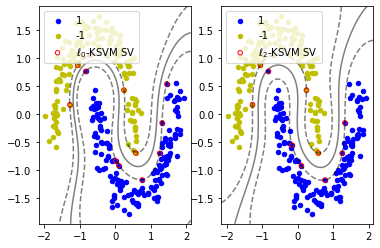

In [9]:
# ##L01KSVM:plot the decision function 
plt.subplot(1,2,1)
#plt.rcParams['figure.dpi'] = 200 #分辨率
plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (9.0, 4.0) 
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)


ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
K_classifier = pairwise_kernels(np.c_[xx.ravel(), yy.ravel()],X_train, metric='rbf') 
Y_classifiervalue=-np.dot(K_classifier,np.multiply(Lambda,y) ) + b  
Z=Y_classifiervalue.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
index_sv=np.nonzero(Lambda)[0] 
sv_L01Loss = X_train[index_sv]  #support vectors for L01KSVM
plt.scatter(sv_L01Loss[:, 0],sv_L01Loss[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_0$-KSVM SV')
plt.legend(loc = 'upper left')
#plt.title('L01KSVM',fontsize=10)
#plt.savefig('L01KSVM__DoubleMoons.png', bbox_inches='tight')

# #HingeKSVM:plot the decision function
plt.subplot(1,2,2)
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.rcParams['font.size'] = '10'
#plt.rcParams['figure.figsize'] = (8.0, 4.0) 
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
plt.scatter(support_vectors[:, 0],support_vectors[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_2$-KSVM SV')
plt.legend(loc = 'upper left')
#plt.title('SquaredHingeKSVM',fontsize=10)
plt.savefig('KSVM_DoubleMoonLabel0_1000.png', bbox_inches='tight')

In [10]:
#Summary
#L01KSVM 
print({'C':C,'sigma':sigma,'iota':iota})
print('Threshold',np.sqrt((2*C)/sigma))
print('KKT error beta',beta.T)
print('Iteration',i+1)
print('Program time of L01KSVM is:%ss'%(str(end-start)))


#dataset
print('Number of Training Data',m)
print('Number of Testing Data',y_test.shape[0])
#Accuracy
print('Train Accuracy of L01KSVM:',accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
print('Test Accuracy of  L01KSVM:',accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))
print('Train accuracy of HingeKSVM:',clf.score(X_train,y_train))
print('Test accuracy of HingeKSVM:',clf.score(X_test,y_test))
#Number of Support Vectors
print('Number of support vectors for L01KSVM',len(index_sv))  
print('Number of support vectors for HingeKSVM:',np.sum(clf.n_support_))
#Indices
print('Indices of support vectors for L01KSVM:\n',index_sv)
print('Indices of support vectors for HingeKSVM:\n',clf.support_)
#Dual Coefficients
print('Lambda with nonzero elements for L01KSVM:\n',Lambda[np.nonzero(Lambda)])
#print('Dual coefficients of the support vector in the decision function:\n',clf.dual_coef_)
#Computation Time
print('Computation Time for L01SVM',end-start)
print('Computation Time for HingeKSVM',end1-start1)

{'C': 64, 'sigma': 1, 'iota': 1}
Threshold 11.313708498984761
KKT error beta [4.93102663e-05 1.01323302e-05 9.98435954e-04 4.23375636e-04]
Iteration 469
Program time of L01KSVM is:0.6539473533630371s
Number of Training Data 300
Number of Testing Data 200
Train Accuracy of L01KSVM: 1.0
Test Accuracy of  L01KSVM: 1.0
Train accuracy of HingeKSVM: 1.0
Test accuracy of HingeKSVM: 1.0
Number of support vectors for L01KSVM 12
Number of support vectors for HingeKSVM: 11
Indices of support vectors for L01KSVM:
 [ 32  43  75  76 123 147 162 212 213 219 260 268]
Indices of support vectors for HingeKSVM:
 [ 43 162 212 219 268  32  75 147 197 213 260]
Lambda with nonzero elements for L01KSVM:
 [  -1.92442894  -48.2181972   -13.30303325   -4.16730006   -0.77273861
  -14.43776557  -34.41516712  -22.23782267 -109.13781902  -40.18332926
  -11.12166847   -9.81327737]
Computation Time for L01SVM 0.6539473533630371
Computation Time for HingeKSVM 0.001993417739868164


Numerical Results

In [11]:
# m=1000, r=0%
#{'C': 64, 'sigma': 1, 'iota': 1}
# Threshold 11.313708498984761
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 563
# Program time of L01KSVM is:5.7991955280303955s
# Number of Training Data 600
# Number of Testing Data 400
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 0.995
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 0.9975
# Number of support vectors for L01KSVM 13
# Number of support vectors for HingeKSVM: 15
# Indices of support vectors for L01KSVM:
#  [  1   5  16 167 191 235 287 294 410 432 501 507 515]
# Indices of support vectors for HingeKSVM:
#  [  5 167 180 287 507 515 589  16  31 149 191 198 235 410 501]
# Lambda with nonzero elements for L01KSVM:
#  [-2.93318335e+00 -1.41904512e+01 -5.59252056e+00 -6.66744510e-02
#  -7.84616972e+00 -8.15762410e+01 -5.44447385e+01 -1.34937720e+00
#  -3.10728100e+01 -1.62567756e+01 -5.55774985e+00 -2.10327617e+01
#  -3.00241310e+01]
# Dual coefficients of the support vector in the decision function:
#  [[-10.32716182  -2.75427384 -16.         -16.         -16.
#   -16.          -4.01058343   3.56430066   7.33050015  11.59895814
#    14.59251      7.0360262   16.          16.           4.96972394]]
# Computation Time for L01SVM 5.7991955280303955
# Computation Time for HingeKSVM 0.003988742828369141

In [12]:
# m=500, r=0%
# {'C': 64, 'sigma': 1, 'iota': 1}  C=64
# Threshold 11.313708498984761
# KKT error beta [7.91929951e-05 2.05135386e-04 9.88733327e-04 4.26825190e-04]
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 644
# Program time of L01KSVM is:1.3134753704071045s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 1.0
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Number of support vectors for L01KSVM 9
# Number of support vectors for HingeKSVM: 10
# Indices of support vectors for L01KSVM:
#  [ 78 111 117 118 164 181 214 273 297]
# Indices of support vectors for HingeKSVM:
#  [ 78 111 118 181 230 297 117 164 214 273]
# Lambda with nonzero elements for L01KSVM:
#  [  -7.84734429 -112.40054211  -21.11713567   -8.03484608  -37.90262064
#    -3.04479061  -63.00067346  -21.43361583  -12.06498189]
# Computation Time for L01SVM 1.3134753704071045
# Computation Time for HingeKSVM 0.0019953250885009766

In [13]:
# m=1500, r=0%
# {'C': 64, 'sigma': 1, 'iota': 1}
# Threshold 11.313708498984761
# KKT error beta [0.00042159 0.00182571 0.02020951 0.00474693]
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:56.16391634941101s
# Number of Training Data 900
# Number of Testing Data 600
# Train Accuracy of L01KSVM: 0.9977777777777778
# Test Accuracy of  L01KSVM: 1.0
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Number of support vectors for L01KSVM 16
# Number of support vectors for HingeKSVM: 16
# Indices of support vectors for L01KSVM:
#  [ 36 119 145 147 216 229 439 538 540 625 674 688 796 834 851 871]
# Indices of support vectors for HingeKSVM:
#  [119 229 439 625 674 834 844 871  36 145 147 216 538 540 688 796]
# Lambda with nonzero elements for L01KSVM:
#  [-104.48529977  -73.33641526  -37.51983235   -4.92249226  -10.11767621
#   -80.11194142  -62.57264731  -98.48034808  -82.21817879   -6.69461235
#   -31.49972174  -31.95956646  -11.44702449 -117.29684566   -5.17891902
#   -13.1740186 ]
# Dual coefficients of the support vector in the decision function:
#  [[-64.         -64.         -64.          -5.5337291  -29.87191169
#   -64.         -12.76120016  -9.82057586  64.          38.28817813
#    24.50405379   7.61689731  64.          64.          50.75061805
#     0.82766951]]
# Computation Time for L01SVM 56.16391634941101
# Computation Time for HingeKSVM 0.004166126251220703

In [14]:
# m=500,  r=1%, {'C': 2, 'sigma': 2, 'iota': 1}
# Threshold 1.4142135623730951
# KKT error beta [0.02979058 0.00246374 0.20184896 0.28055343]
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:2.9009389877319336s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.97
# Test Accuracy of  L01KSVM: 0.985
# Train accuracy of HingeKSVM: 0.9766666666666667
# Test accuracy of HingeKSVM: 0.985
# Number of support vectors for L01KSVM 33
# Number of support vectors for HingeKSVM: 35
# Indices of support vectors for L01KSVM:
#  [  9  26  54  78 100 109 111 112 116 117 118 121 125 148 164 168 172 176
#  181 184 190 196 214 215 218 221 236 259 260 267 273 278 297]
# Indices of support vectors for HingeKSVM:
#  [  9  21  44  78 111 116 118 133 139 153 170 181 230 250 253 267 297 117
#  121 129 134 148 149 164 185 187 189 194 214 215 244 260 273 289 292]
# Lambda with nonzero elements for L01KSVM:
#  [ 0.00797572 -0.32051676 -3.76204124 -1.12128715 -0.74501018 -0.08244515
#  -2.59887504 -1.94996214 -0.94477982 -3.77794179 -2.85396701 -1.86772922
#  -1.59137739 -0.14560412 -3.12593787 -2.97955394 -0.64956743 -0.53084448
#  -1.19423496 -3.48556306 -2.20130534 -0.57987726 -3.69686432 -1.49812297
#  -2.65585204 -0.44435256 -2.49746941 -3.19674743 -0.31842703 -2.79698253
#  -1.91098409 -1.26004356 -1.64650293]
# Computation Time for L01SVM 2.9009389877319336
# Computation Time for HingeKSVM 0.00432586669921875

In [15]:
# m=500,r=5%
#{'C': 2, 'sigma': 2, 'iota': 1}
# Threshold 1.4142135623730951
# KKT error beta [0.0689619  0.00346087 0.22852315 0.2348679 ]
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:2.7592997550964355s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.8966666666666666
# Test Accuracy of  L01KSVM: 0.89
# Train accuracy of HingeKSVM: 0.8966666666666666
# Test accuracy of HingeKSVM: 0.895
# Number of support vectors for L01KSVM 36
# Number of support vectors for HingeKSVM: 84
# Indices of support vectors for L01KSVM:
#  [  2   7  10  28  35  71  78  79  99 117 118 121 125 148 164 168 172 176
#  179 181 184 196 214 215 218 221 224 236 259 260 267 273 277 278 280 297]
# Indices of support vectors for HingeKSVM:
#  [  9  12  16  21  29  35  44  54  70  73  78  97  99 100 111 116 118 125
#  126 131 133 137 139 153 154 162 170 184 192 221 225 230 232 236 250 253
#  259 267 269 283 286 297   7  20  42  50  61  71  95 104 112 117 121 138
#  144 148 149 159 161 164 172 176 177 179 185 187 190 194 196 204 205 214
#  218 224 235 244 247 256 260 262 273 278 293 294]
# Lambda with nonzero elements for L01KSVM:
#  [-1.77663152 -0.43524377 -0.73820646 -0.04681013 -3.60687528 -1.19558509
#  -1.61326691 -3.06298756 -2.7661565  -1.40773922 -2.30428874 -2.33474563
#  -1.47815393 -0.14900228 -2.81081983 -0.74318533 -2.03870109 -0.66289496
#  -0.69803935 -1.21851565 -3.68373774 -0.17932125 -2.4975993  -3.89185985
#  -2.543927   -2.73111089 -0.03464658 -3.22927999 -3.97539733 -0.19479481
#  -2.63760121 -2.83172449 -0.82024649 -0.80703995 -3.1133903  -1.08561316]
# Dual coefficients of the support vector in the decision function:
#  [[-16.         -16.          -4.96493337 -16.         -16.
#   -16.          -6.40756993 -16.         -16.         -16.
#   -16.         -16.         -12.22298392 -16.         -16.
#   -16.         -16.         -16.         -16.         -16.
#   -16.         -12.87223228  -9.74178926 -16.          -5.15648378
#   -16.         -16.         -16.          -3.092308   -16.
#   -16.         -16.         -16.         -16.          -0.77202026
#   -16.         -16.         -16.         -16.         -16.
#    -5.188704   -16.           7.03831355  16.          16.
#    16.          11.09507751  16.          16.          16.
#    16.          16.          16.           9.65994427  16.
#    16.          16.          16.          16.          16.
#    16.           8.42409834  16.          16.           2.71387332
#    16.          16.          16.          16.           9.45865877
#     3.17019035  16.          16.           3.49988527  16.
#    16.          16.          16.          16.          16.
#    16.          16.           5.35898341  16.        ]]
# Computation Time for L01SVM 2.7592997550964355
# Computation Time for HingeKSVM 0.003987312316894531

In [16]:
# m=500, r=10%, {'C': 1, 'sigma': 2, 'iota': 1}
# Threshold 1.0
# KKT error beta [0.04374174 0.0029623  0.14750265 0.13700551]
# KKT condition (tolerance level=1e-3) is satisfied with iteration i:= 2000
# Program time of L01KSVM is:2.676518678665161s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.8
# Test Accuracy of  L01KSVM: 0.78
# Train accuracy of HingeKSVM: 0.81
# Test accuracy of HingeKSVM: 0.78
# Number of support vectors for L01KSVM 40
# Number of support vectors for HingeKSVM: 137
# Indices of support vectors for L01KSVM:
#  [  7  10  11  26  28  51  71  78  79  99 100 108 109 116 117 118 119 124
#  125 128 164 167 168 172 179 181 183 196 215 218 220 224 259 260 266 273
#  277 278 280 291]
# Indices of support vectors for HingeKSVM:
#  [  2   9  12  16  21  29  35  38  39  44  46  49  53  54  70  73  78  89
#   90  97  98  99 100 111 113 114 116 118 121 125 126 131 133 135 137 139
#  148 153 154 160 161 162 167 170 176 180 181 182 184 185 189 192 195 203
#  213 214 221 225 229 230 232 236 253 259 269 271 282 283 286 297   7  13
#   20  43  50  55  59  61  63  67  82  94  95 104 107 112 117 120 128 129
#  134 138 141 144 146 149 151 156 157 159 164 172 173 175 177 179 187 188
#  190 194 196 200 204 205 217 218 227 235 242 244 247 254 256 257 260 262
#  264 265 267 273 278 285 289 290 292 293 294]
# Lambda with nonzero elements for L01KSVM:
#  [-1.29601757e-01 -7.96259482e-01 -1.90593692e+00 -1.07822574e+00
#  -1.13098197e+00 -1.91520485e+00 -1.72787165e+00 -1.66466729e+00
#  -4.18225071e-01 -1.64515277e+00 -2.67769269e-01 -4.99662140e-01
#  -1.48428768e+00 -2.66978835e-01 -1.51551609e+00 -1.74273785e+00
#  -2.55451793e-02 -8.69128096e-01 -1.73209607e+00  5.25110537e-04
#  -1.52113751e+00 -8.97730785e-01 -2.85608328e-01 -1.17447006e+00
#  -1.27572337e+00 -8.76062838e-01 -1.57337520e+00 -1.56753112e+00
#  -7.39086640e-01 -1.42235509e+00 -5.19768299e-01 -3.63562284e-02
#  -2.00116644e+00 -6.57468548e-02 -3.38082444e-01 -1.46570787e+00
#  -8.30683110e-01 -1.79280822e+00 -1.89342946e+00 -1.07962054e+00]
# Computation Time for L01SVM 2.676518678665161
# Computation Time for HingeKSVM 0.013963699340820312